
Threshold value: 1.221
Number of high occupancy indices: 40439
Number of low occupancy indices: 121238

High occupancy group bases:
           site  value base
0      168792.0  4.142    C
1      168793.0  4.142    T
2      168798.0  4.127    G
3      168796.0  4.120    C
4      168799.0  4.120    C
...         ...    ...  ...
40434  179691.0  1.221    T
40435  179692.0  1.221    C
40436  190355.0  1.221    A
40437  191353.0  1.221    T
40438  191720.0  1.221    T

[40439 rows x 3 columns]

Low occupancy group bases:
            site   value base
40439    43406.0  1.2200    T
40440    45447.0  1.2200    A
40441    45448.0  1.2200    G
40442    45449.0  1.2200    A
40443    46046.0  1.2200    C
...          ...     ...  ...
161672  199945.0  0.0155    A
161673  199946.0  0.0155    A
161674  199947.0  0.0155    A
161675  199948.0  0.0155    T
161676  199949.0  0.0155    T

[121238 rows x 3 columns]

High Occupancy Group nucleotide percentages:
A base percentage: 27.28%
T base percentage:

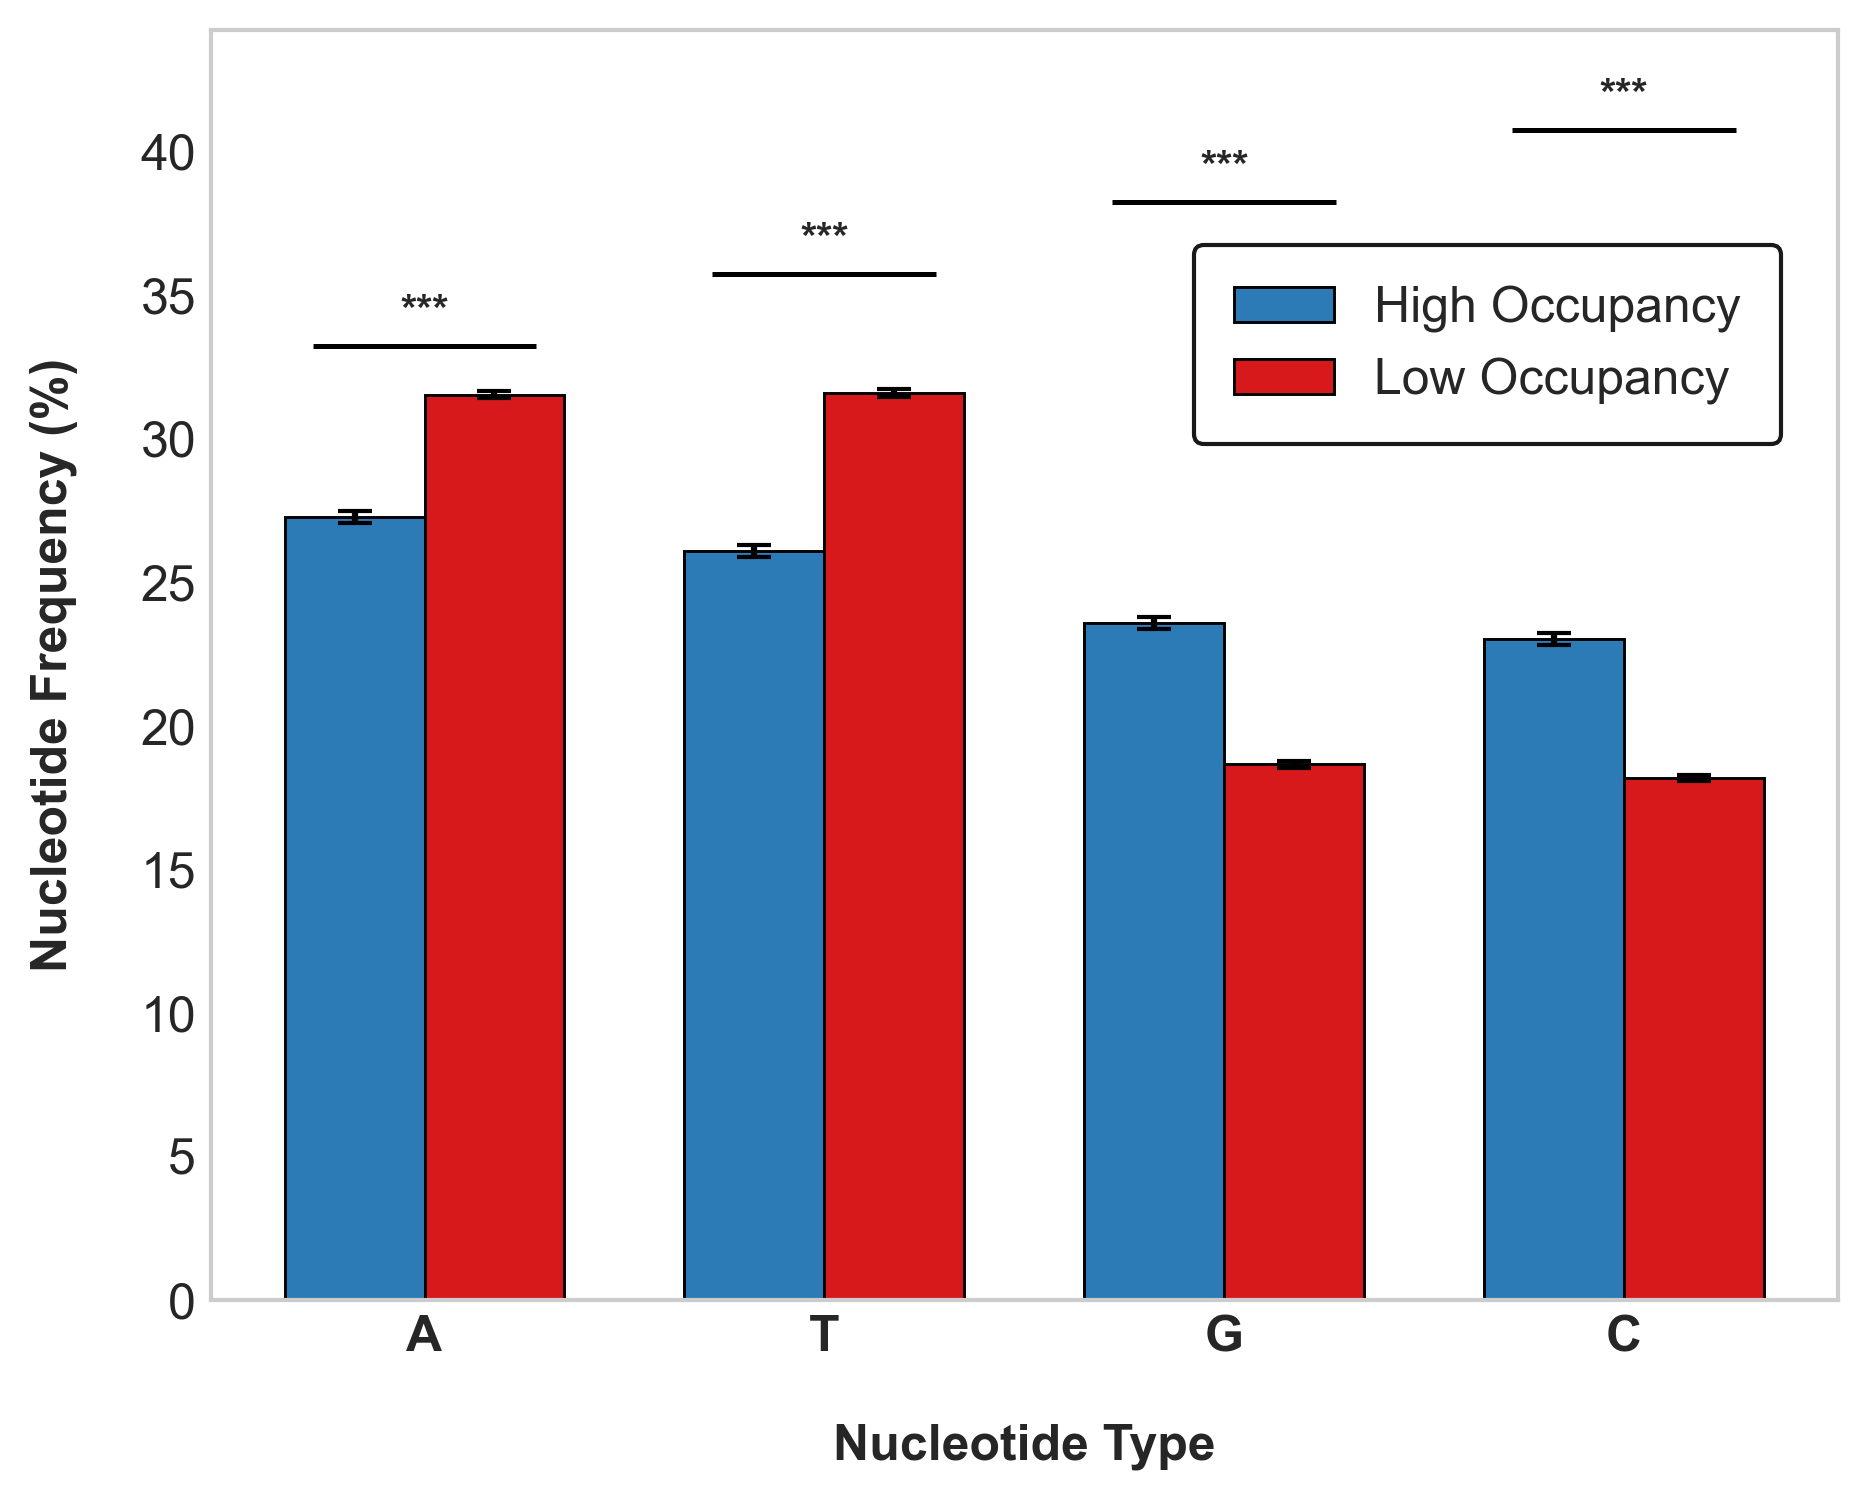

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
import os

# ==========================
# 0. 学术图表全局参数设置
# ==========================
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': 'Arial',
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.format': 'pdf',
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
    'errorbar.capsize': 4  # 误差线帽宽优化
})

# ==========================
# 1. 数据加载与处理
# ==========================
file_path = "测试位点和占据率/ch1测试.csv"
occupancy_data = pd.read_csv(file_path, usecols=[0, 1])

# 计算阈值并分类
threshold = np.percentile(occupancy_data.iloc[:, 1], 75)
print(f"\nThreshold value: {threshold:.3f}")

high_occupancy_indices = occupancy_data.iloc[:, 1] >= threshold
low_occupancy_indices = occupancy_data.iloc[:, 1] < threshold

print(f"Number of high occupancy indices: {sum(high_occupancy_indices)}")
print(f"Number of low occupancy indices: {sum(low_occupancy_indices)}")

high_occupancy_group = occupancy_data[high_occupancy_indices].copy()
low_occupancy_group = occupancy_data[low_occupancy_indices].copy()

# ==========================
# 2. 基因组序列处理
# ==========================
genome_file_path = "SAC1基因组去空格/CH1n.txt"
with open(genome_file_path, 'r') as file:
    genome_sequence = file.read().strip()

def extract_bases_from_genome(group, genome_sequence):
    bases = []
    for index, row in group.iterrows():
        position = int(row.iloc[0])
        if position >= len(genome_sequence):
            bases.append(None)
        else:
            bases.append(genome_sequence[position])
    return bases

high_occupancy_group['base'] = extract_bases_from_genome(high_occupancy_group, genome_sequence)
low_occupancy_group['base'] = extract_bases_from_genome(low_occupancy_group, genome_sequence)

print("\nHigh occupancy group bases:")
print(high_occupancy_group)
print("\nLow occupancy group bases:")
print(low_occupancy_group)

# ==========================
# 3. 单核苷酸统计分析（误差计算与显著性检验）
# ==========================
def calculate_nucleotide_data(sequences):
    counts = {'A':0, 'T':0, 'G':0, 'C':0}
    for base in sequences.dropna():
        if base in counts:
            counts[base] += 1
    total = sum(counts.values())
    percentages = {k: (v/total)*100 if total>0 else 0 for k,v in counts.items()}
    return counts, percentages, total

# 计算高/低组数据
high_counts, high_percent, total_high = calculate_nucleotide_data(high_occupancy_group['base'])
low_counts, low_percent, total_low = calculate_nucleotide_data(low_occupancy_group['base'])

print("\nHigh Occupancy Group nucleotide percentages:")
for base in ['A', 'T', 'G', 'C']:
    print(f"{base} base percentage: {high_percent[base]:.2f}%")

print("\nLow Occupancy Group nucleotide percentages:")
for base in ['A', 'T', 'G', 'C']:
    print(f"{base} base percentage: {low_percent[base]:.2f}%")

# 计算标准误（精确计算）
def calculate_se(p_percent, n):
    p = p_percent / 100.0
    se = np.sqrt(p * (1 - p) / n) * 100 if n > 0 else 0
    return se

high_err = {base: calculate_se(high_percent[base], total_high) for base in ['A', 'T', 'G', 'C']}
low_err = {base: calculate_se(low_percent[base], total_low) for base in ['A', 'T', 'G', 'C']}

# 执行比例z检验
p_values = {}
for base in ['A', 'T', 'G', 'C']:
    count = [high_counts[base], low_counts[base]]
    nobs = [total_high, total_low]
    _, p = proportions_ztest(count, nobs, alternative='two-sided')
    p_values[base] = p

# ==========================
# 4. 单核苷酸高级可视化设计（精确标注与布局）
# ==========================
nucleotides = ['A', 'T', 'G', 'C']
x = np.arange(len(nucleotides))
width = 0.35
color_high = '#2c7bb6'  # 优化颜色对比度
color_low = '#d7191c'

fig, ax = plt.subplots(figsize=(7, 5.5))  # 优化画布比例

# 绘制柱状图与误差线
rects_high = ax.bar(x - width/2, [high_percent[base] for base in nucleotides],
                    width, color=color_high, edgecolor='black', linewidth=0.7,
                    yerr=[high_err[base] for base in nucleotides], label='High Occupancy')

rects_low = ax.bar(x + width/2, [low_percent[base] for base in nucleotides],
                   width, color=color_low, edgecolor='black', linewidth=0.7,
                   yerr=[low_err[base] for base in nucleotides], label='Low Occupancy')

# 显著性标注系统
def get_stars(p):
    if p < 0.001: return '***'
    elif p < 0.01: return '**'
    elif p < 0.05: return '*'
    else: return 'NS'

# 动态计算标注位置
max_y = max([high_percent[base] + high_err[base] for base in nucleotides] +
            [low_percent[base] + low_err[base] for base in nucleotides]) 
y_start = max_y + 1.5
y_increment = 2.5

for i, base in enumerate(nucleotides):
    p = p_values[base]
    if p < 0.05:
        # 绘制水平线
        ax.hlines(y_start, x[i]-width*0.8, x[i]+width*0.8, 
                  colors='black', linewidth=1.2, linestyles='solid')
        # 添加星标
        ax.text(x[i], y_start + 0.5, get_stars(p),
                ha='center', va='bottom', fontsize=10, fontweight='bold')
        y_start += y_increment

# 坐标轴优化
ax.set_ylabel('Nucleotide Frequency (%)', fontweight='bold', labelpad=15)
ax.set_xlabel('Nucleotide Type', fontweight='bold', labelpad=15)
ax.set_xticks(x)
ax.set_xticklabels(nucleotides, fontweight='bold')
ax.set_ylim(0, y_start + 1) 

# 图例优化
legend = ax.legend(
    frameon=True,
    framealpha=0.9,
    edgecolor='black',
    loc='upper right',
    bbox_to_anchor=(0.98, 0.85),
    borderpad=0.8)
plt.setp(legend.get_title(), fontweight='bold')

ax.yaxis.grid(False)  # 关闭纵坐标刻度线
ax.xaxis.grid(False)  # 关闭横坐标刻度线

# 保存单核苷酸结果
save_path = os.path.join("可视化图", "单核苷酸偏好柱形图.pdf")
plt.savefig(save_path, bbox_inches='tight')
plt.show()


Threshold value: 1.221
Number of high occupancy indices: 40439
Number of low occupancy indices: 121238

High occupancy group bases:
           site  value base
0      168792.0  4.142    C
1      168793.0  4.142    T
2      168798.0  4.127    G
3      168796.0  4.120    C
4      168799.0  4.120    C
...         ...    ...  ...
40434  179691.0  1.221    T
40435  179692.0  1.221    C
40436  190355.0  1.221    A
40437  191353.0  1.221    T
40438  191720.0  1.221    T

[40439 rows x 3 columns]

Low occupancy group bases:
            site   value base
40439    43406.0  1.2200    T
40440    45447.0  1.2200    A
40441    45448.0  1.2200    G
40442    45449.0  1.2200    A
40443    46046.0  1.2200    C
...          ...     ...  ...
161672  199945.0  0.0155    A
161673  199946.0  0.0155    A
161674  199947.0  0.0155    A
161675  199948.0  0.0155    T
161676  199949.0  0.0155    T

[121238 rows x 3 columns]


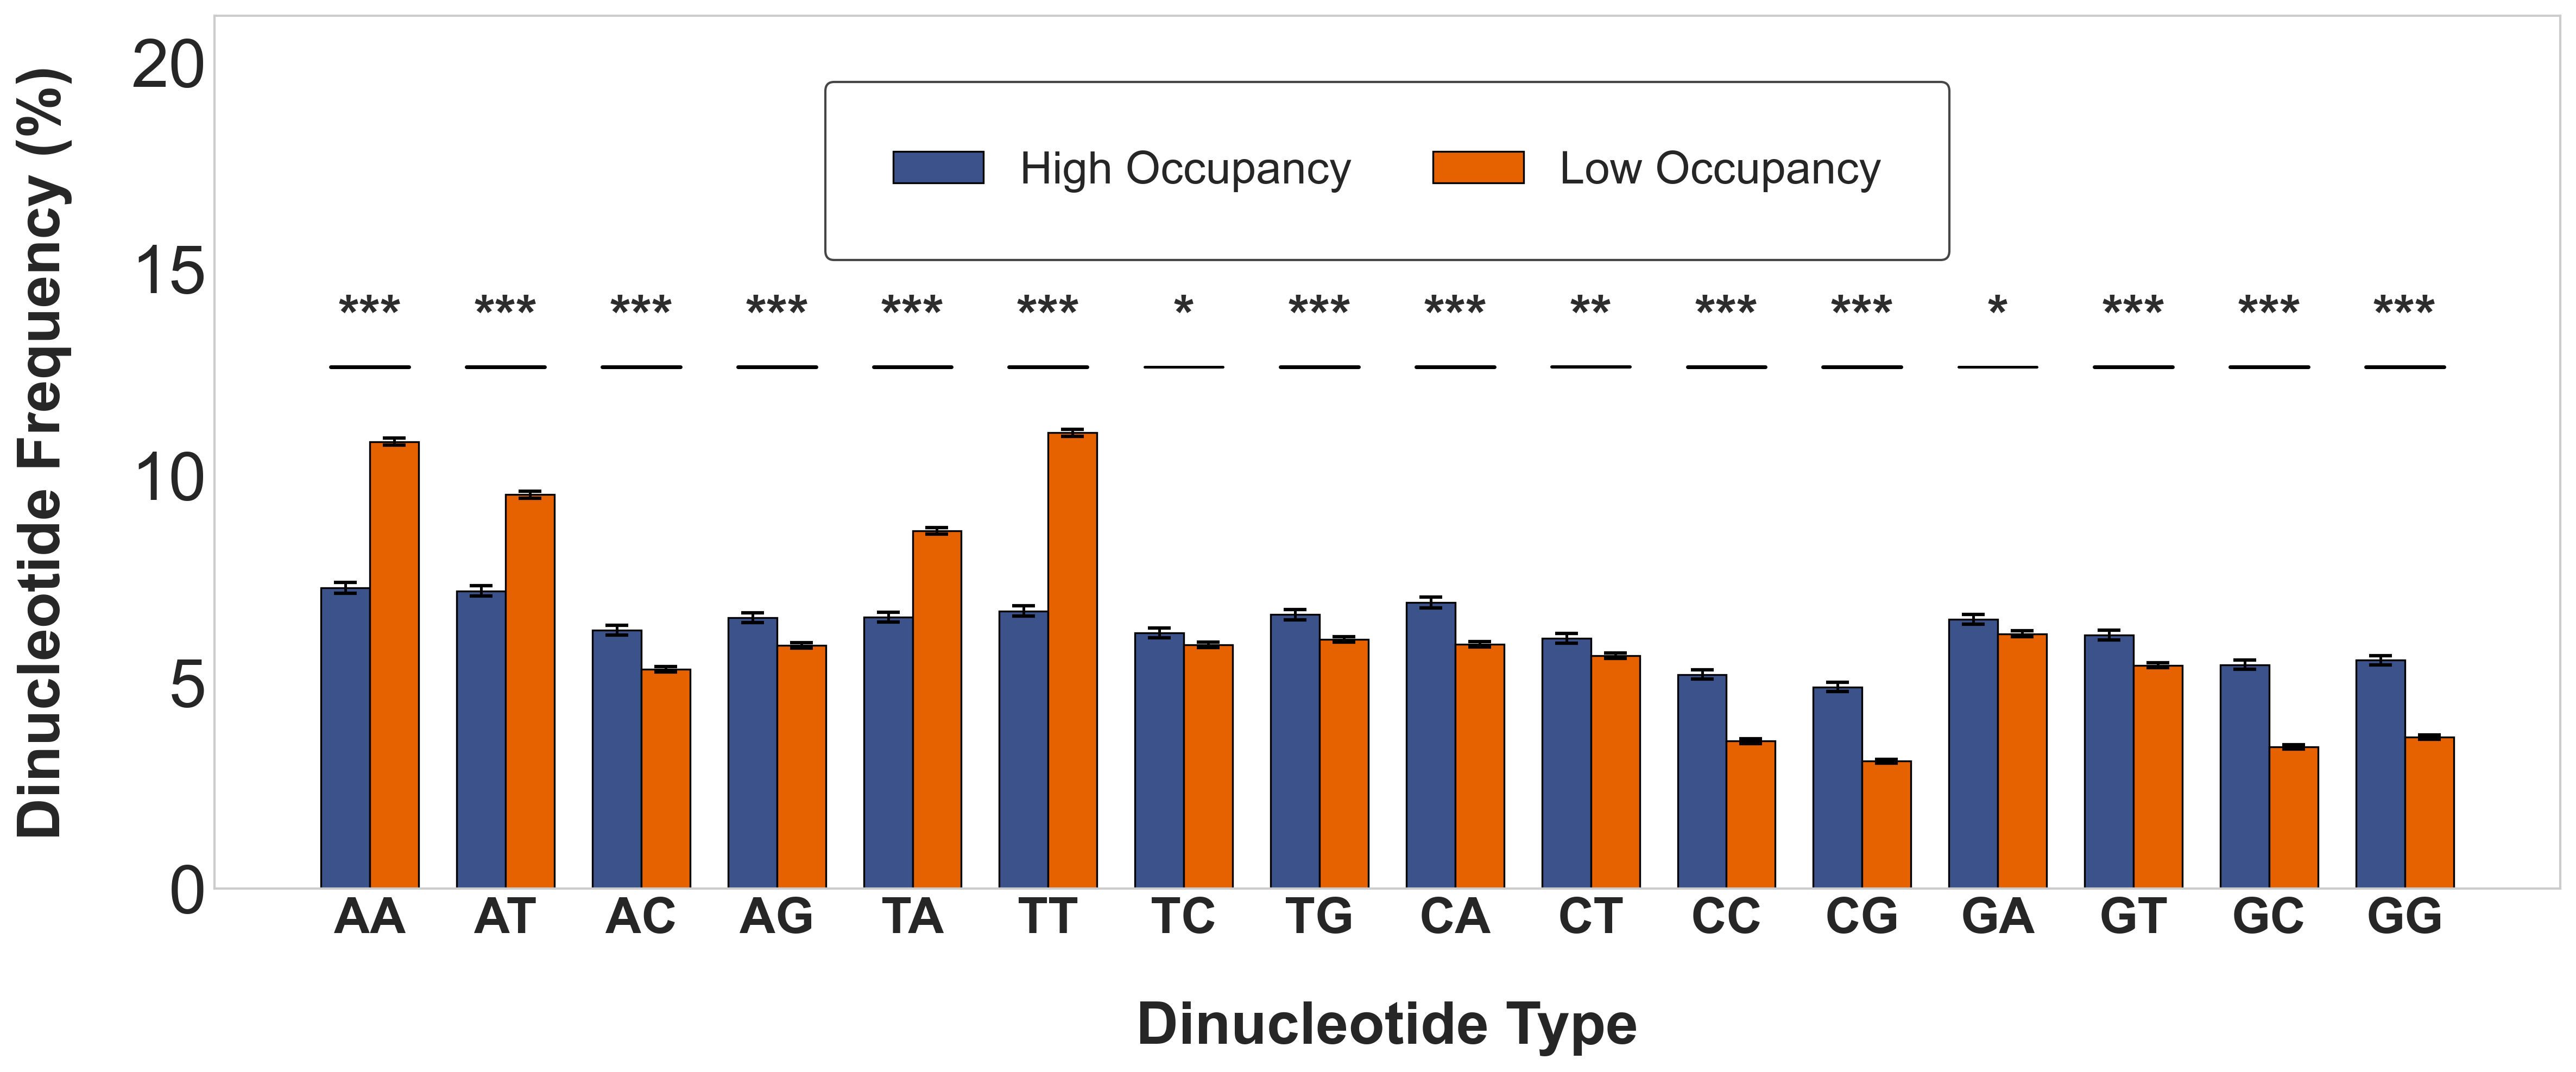

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
import os

# ==========================
# 0. 学术图表全局参数设置
# ==========================
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': 'Arial',
    'font.size': 30,
    'axes.titlesize': 30,
    'axes.labelsize': 30,
    'xtick.labelsize': 30,
    'ytick.labelsize': 30,
    'legend.fontsize': 30,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.format': 'pdf',
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
    'errorbar.capsize': 4  # 误差线帽宽优化
})

# ==========================
# 1. 数据加载与处理
# ==========================
file_path = "测试位点和占据率/ch1测试.csv"
occupancy_data = pd.read_csv(file_path, usecols=[0, 1])

# 计算阈值并分类
threshold = np.percentile(occupancy_data.iloc[:, 1], 75)
print(f"\nThreshold value: {threshold:.3f}")

high_occupancy_indices = occupancy_data.iloc[:, 1] >= threshold
low_occupancy_indices = occupancy_data.iloc[:, 1] < threshold

print(f"Number of high occupancy indices: {sum(high_occupancy_indices)}")
print(f"Number of low occupancy indices: {sum(low_occupancy_indices)}")

high_occupancy_group = occupancy_data[high_occupancy_indices].copy()
low_occupancy_group = occupancy_data[low_occupancy_indices].copy()

# ==========================
# 2. 基因组序列处理
# ==========================
genome_file_path = "SAC1基因组去空格/CH1n.txt"
with open(genome_file_path, 'r') as file:
    genome_sequence = file.read().strip()

def extract_bases_from_genome(group, genome_sequence):
    bases = []
    for index, row in group.iterrows():
        position = int(row.iloc[0])
        if position >= len(genome_sequence):
            bases.append(None)
        else:
            bases.append(genome_sequence[position])
    return bases

high_occupancy_group['base'] = extract_bases_from_genome(high_occupancy_group, genome_sequence)
low_occupancy_group['base'] = extract_bases_from_genome(low_occupancy_group, genome_sequence)

print("\nHigh occupancy group bases:")
print(high_occupancy_group)
print("\nLow occupancy group bases:")
print(low_occupancy_group)

# ==========================
# 3. 二核苷酸统计分析系统
# ==========================
def calculate_dinucleotide_stats(sequences):
    dinucleotides = ['AA','AT','AC','AG','TA','TT','TC','TG','CA','CT','CC','CG','GA','GT','GC','GG']
    counts = {dn:0 for dn in dinucleotides}
    total = 0
    
    valid_sequences = [b for b in sequences if pd.notnull(b)]
    for i in range(len(valid_sequences)-1):
        dn = valid_sequences[i] + valid_sequences[i+1]
        if dn in counts:
            counts[dn] += 1
            total += 1
    
    percentages = {dn: (count/total)*100 if total>0 else 0 for dn, count in counts.items()}
    se = {dn: np.sqrt((p/100)*(1-p/100)/total)*100 if total>0 else 0 for dn, p in percentages.items()}
    
    return counts, percentages, se, total

# 计算各组数据
high_counts, high_dn_percent, high_dn_se, high_total = calculate_dinucleotide_stats(high_occupancy_group['base'])
low_counts, low_dn_percent, low_dn_se, low_total = calculate_dinucleotide_stats(low_occupancy_group['base'])

# 显著性检验
dn_pvalues = {}
for dn in high_dn_percent.keys():
    count = [high_counts[dn], low_counts[dn]]
    nobs = [high_total, low_total]
    _, p = proportions_ztest(count, nobs, alternative='two-sided')
    dn_pvalues[dn] = p

# ==========================
# 4. 二核苷酸高级可视化系统
# ==========================
# 参数配置
COLOR_PALETTE = {
    'high': '#3B528B',  # 深蓝
    'low': '#E66100'    # 橙红
}
SIGNIFICANCE_LEVELS = {
    0.001: ('***', 1.4),  # 按阈值降序排列
    0.01: ('**', 1.2),
    0.05: ('*', 1.0)
}

# 创建画布系统
fig, ax = plt.subplots(figsize=(16, 8), dpi=300)  # 增大画布尺寸
plt.subplots_adjust(left=0.07, right=0.97, top=0.92, bottom=0.25)

# 可视化引擎
dinucleotides = ['AA','AT','AC','AG','TA','TT','TC','TG','CA','CT','CC','CG','GA','GT','GC','GG']
x = np.arange(len(dinucleotides))
width = 0.36
bar_params = {
    'linewidth': 0.8,
    'edgecolor': 'black',
    'error_kw': {
        'elinewidth': 1.2,
        'capthick': 1.5,
        'capsize': 5
    }
}

# 绘制高质量柱状图
high_bars = ax.bar(x - width/2, [high_dn_percent[dn] for dn in dinucleotides],
                   width, color=COLOR_PALETTE['high'],
                   yerr=[high_dn_se[dn] for dn in dinucleotides],
                   label='High Occupancy', **bar_params)

low_bars = ax.bar(x + width/2, [low_dn_percent[dn] for dn in dinucleotides],
                  width, color=COLOR_PALETTE['low'],
                  yerr=[low_dn_se[dn] for dn in dinucleotides],
                  label='Low Occupancy', **bar_params)

# 动态标注系统
def auto_annotation(ax, pvalues, y_base):
    y_levels = {}
    for idx, (dn, p) in enumerate(pvalues.items()):
        if p >= 0.05:
            continue
        
        # 初始化默认值
        symbol, line_scale = '', 1.0
        
        # 按阈值降序检查
        for cutoff in sorted(SIGNIFICANCE_LEVELS.keys()):
            if p < cutoff:
                symbol, line_scale = SIGNIFICANCE_LEVELS[cutoff]
                break  # 找到最严格阈值后立即退出
        
        # 跳过无显著性的情况
        if not symbol:
            continue
            
        # 动态高度分配
        x_pos = x[idx]
        current_y = y_base
        while (x_pos, current_y) in y_levels:
            current_y += 3
        
        y_levels[(x_pos, current_y)] = True
        
        # 绘制标注元素
        ax.plot([x_pos - width*0.8, x_pos + width*0.8],
                [current_y, current_y], 
                color='black', 
                linewidth=1.2*line_scale,
                solid_capstyle='round')
        
        ax.text(x_pos, current_y + 0.8, symbol,
                ha='center', va='baseline',
                fontsize=24, fontweight='bold',  # 增大星标字体
                color='#2d2d2d')

# 执行智能标注
max_y = max([h + e for h, e in zip(high_dn_percent.values(), high_dn_se.values())] +
         [l + e for l, e in zip(low_dn_percent.values(), low_dn_se.values())])
auto_annotation(ax, dn_pvalues, y_base=max_y + 1.5)

# 坐标系统优化
ax.set_ylim(0, max_y + 10)  # 增加上边距
ax.set_ylabel('Dinucleotide Frequency (%)', 
             fontsize=26, fontweight='bold', labelpad=26)  # 增大y轴标签字体
ax.set_xlabel('Dinucleotide Type', 
             fontsize=26, fontweight='bold', labelpad=26)  # 增大x轴标签字体
ax.set_xticks(x)
ax.set_xticklabels(dinucleotides, 
                  rotation=0,  # 标签正放
                  ha='center',
                  fontsize=22,  # 增大x轴刻度标签字体
                  fontweight='semibold')

# 专业图例系统
legend = ax.legend(
    frameon=True,
    framealpha=0.97,
    edgecolor='#404040',
    facecolor='white',
    fontsize=20,  # 增大图例字体
    ncol=2,
    loc='upper center',
    bbox_to_anchor=(0.5, 0.95),  # 提升图例位置
    borderpad=1.5,
    columnspacing=1.8
)

# 增大图例文本字体
plt.setp(legend.get_texts(), fontsize='20')
plt.setp(legend.get_title(), fontsize='20')

ax.yaxis.grid(False)  # 关闭纵坐标刻度线
ax.xaxis.grid(False)  # 关闭横坐标刻度线

# 保存二核苷酸结果
save_path = os.path.join("可视化图", "二核苷酸偏好柱形图.pdf")
plt.savefig(save_path, bbox_inches='tight', metadata={'CreationDate': None})
plt.show()